In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[6]",pyFiles=['lib/spark_PCA.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline
import sys
sys.path.append('./lib')

import numpy as np
from spark_PCA import computeCov


Populating the interactive namespace from numpy and matplotlib


In [2]:
df=sqlContext.read.csv('../SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [3]:
columns=df.columns
col=[c for c in columns if '_P' in c]
tickers=[a[:-2] for a in col]
tickers[:10],len(tickers)

(['AGN', 'EOG', 'WLP', 'CPB', 'YUM', 'JWN', 'TAP', 'BWA', 'WM', 'SPG'], 481)

In [34]:
def get_seq(ticker):
    key=ticker+"_P"
    L=df.select(key).collect()
    L=[x[key] for x in L if not x[key] is None]
    return L

In [90]:
def calc_splitpoints(R,count):
    return arange(R[0],R[1],(R[1]-R[0])/(count*1.00001))
def Box_count(LL,ticker):
    X_range=[0,len(LL)]
    Y_range=[min(LL),max(LL)]
    Y_range,X_range

    max_exp=12
    N=np.zeros([max_exp,2])
    covers={}
    for E in range(max_exp):
        count=2**E
        X=[int(x) for x in calc_splitpoints(X_range,count)]
        Ystep=(Y_range[1]-Y_range[0])/count

        T=np.zeros(count)
        blocks=[]
        for i in range(count):
            xmin,xmax=X[i:i+2]
            S=LL[xmin:xmax]
            _ymin=floor(min(S)/Ystep)
            ymin=_ymin*Ystep
            _ymax=ceil(max(S)/Ystep)
            ymax=_ymax*Ystep
            T[i]=_ymax-_ymin
            blocks.append((xmin,xmax,ymin,ymax))
        covers[E] = blocks
        N[E,:]=[count,sum(T)]
    dim=(log(N[-1,1])-log(N[4,1]))/(log(N[-1,0])-log(N[4,0]))
    print 'dim=',dim
    plot(log(N[:,0]),log(N[:,1]));
    title('Box Count Graph for '+ticker)
    xlabel('log 1/epsilon')
    ylabel('log N');
    grid()
    return N,dim,covers

In [91]:
def analyze_sequence(L,ticker):
    figure(figsize=(13,5))
    subplot(121)
    LL=log(L)
    plot(LL)
    title('time series for '+ticker)
    xlabel('days')
    ylabel('log price')
    grid()
    subplot(122)
    N,dim,covers=Box_count(LL,ticker)
    return N,dim,covers

In [121]:
def analyze_stock(ticker):
    L=get_seq(ticker)
    N,dim,covers=analyze_sequence(L,ticker)
    return N,dim,covers,L

dim= 1.2838918282


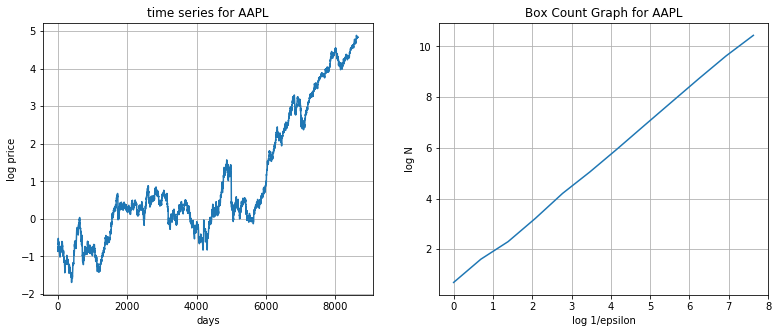

In [122]:
ticker='AAPL'
N,dim,covers,L=analyze_stock(ticker)

In [95]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [125]:
def plot_boxes(LL,covers):
    figure(figsize=[15,10])
    plot(LL)
    axes=gca()
    colors='gbrygbrygbrygbry'
    for level in range(3,8):
        blocks=covers[level]

        for xmin,xmax,ymin,ymax in blocks:
            width=xmax-xmin
            height=ymax-ymin 
            axes.add_patch(
                patches.Rectangle(
                    (xmin, ymin),   # (x,y)
                    width,          # width
                    height,          # height
                    alpha=0.2,color=colors[level]
                ))

dim= 1.34006324586


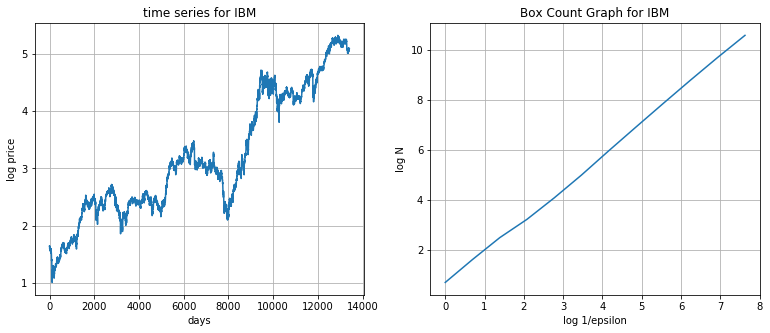

In [128]:
ticker='IBM'
N,dim,covers,L=analyze_stock(ticker)

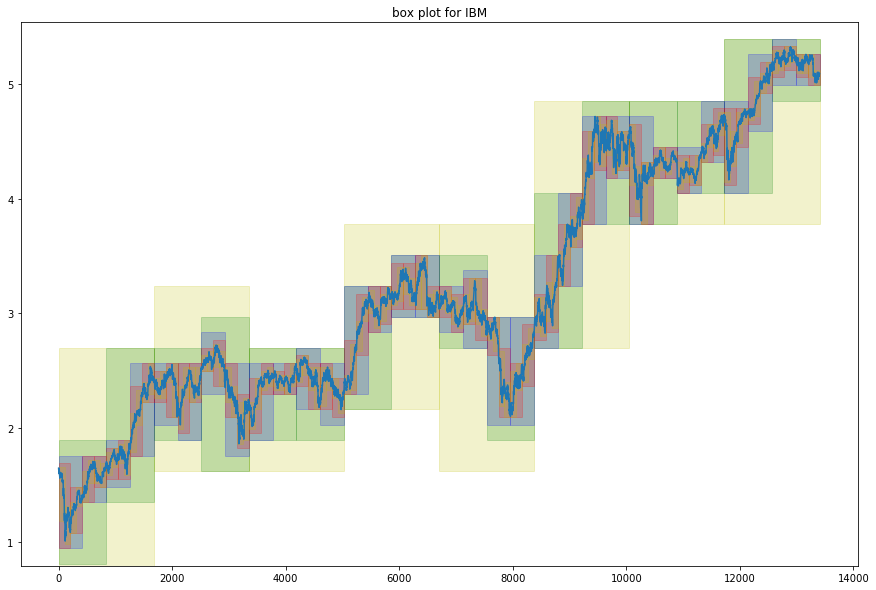

In [129]:
LL=log(L)
plot_boxes(LL,covers)
title('box plot for '+ticker)



In [97]:
x=arange(-1,1,0.0001)
y=exp(sin(8*x))

dim= 0.99061884018


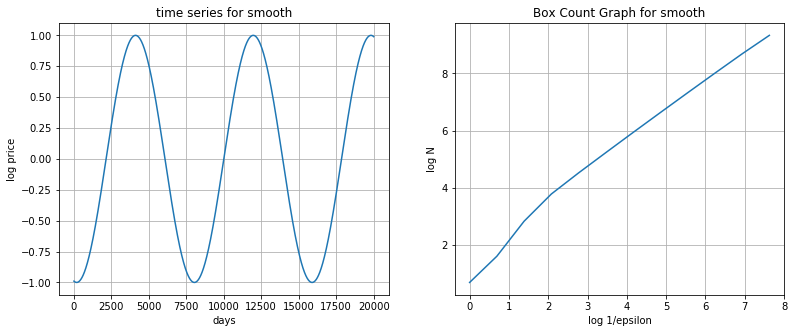

In [130]:
N,dim,covers=analyze_sequence(y,'smooth')

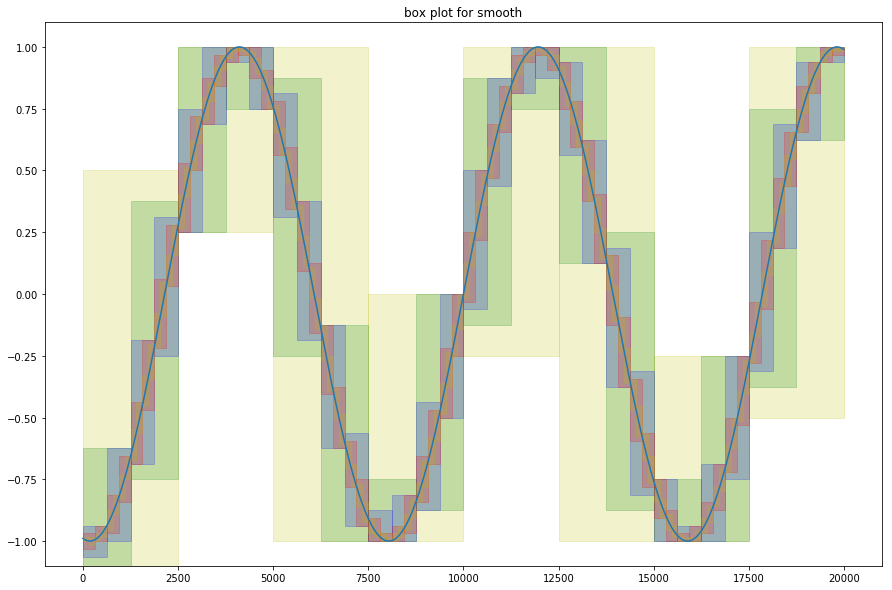

In [132]:
LL=log(y)
plot_boxes(LL,covers)
title('box plot for '+'smooth')

dim= 2.0


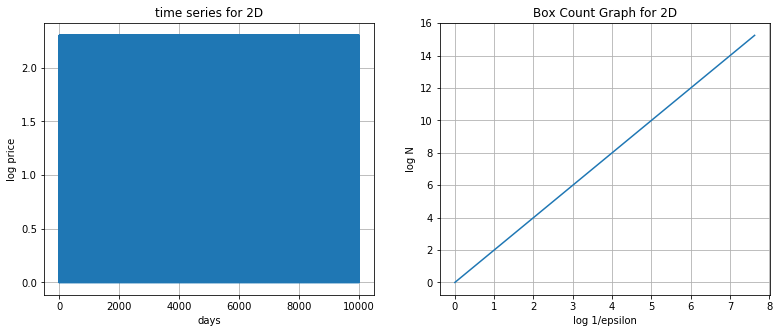

In [100]:
L=np.array([1.,10.]*5000)
X=analyze_sequence(L,'2D')

dim= 1.27359189668


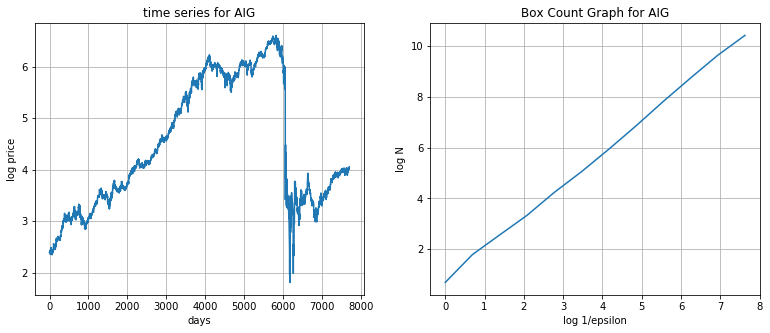

In [43]:
analyze_stock('AIG')

In [89]:
floor(1.9)

1.0